In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy as sp
import skimage.filters as skf
import sys
import warnings
import numexpr as ne
from scipy import optimize as sio
from scipy import ndimage as scnd
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_scalebar.scalebar import SI_LENGTH_RECIPROCAL
from matplotlib.offsetbox import AnchoredText
import matplotlib as mpl
import math
import sys
import numba
import dask
from skimage.transform import rescale as skitres
%matplotlib inline
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams.update({'font.size': 30})
plt.rcParams.update({'font.weight': 'bold'})

In [2]:
warnings.filterwarnings('ignore')
#sys.path.append('/home/cades/Codes/stemtools')
sys.path.append('/home/cades/Codes/stemtools')
import stemtools as st
%load_ext autoreload
%load_ext Cython
%autoreload 2

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(memory_limit='auto', threads_per_worker=4)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:33705 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 20 Cores: 80 Memory: 523.10 GB


In [4]:
def cart2pol(x, y):
    rho = ne.evaluate("((x**2) + (y**2)) ** 0.5")
    phi = ne.evaluate("arctan2(y, x)")
    return (rho, phi)

def pol2cart(rho, phi):
    x = ne.evaluate("rho * cos(phi)")
    y = ne.evaluate("rho * sin(phi)")
    return (x, y)

def angle_fun(angle,rho_dpc,phi_dpc):
    x_dpc,y_dpc = pol2cart(rho_dpc,(phi_dpc + (angle*((np.pi)/180))))
    charge = np.gradient(x_dpc)[1] + np.gradient(y_dpc)[0]
    angle_sum = np.sum(np.abs(charge))
    return angle_sum

def optimize_angle(x_dpc,y_dpc,adf_stem):
    flips = np.zeros(4,dtype=bool)
    flips[2:4] = True
    chg_sums = np.zeros(4,dtype=x_dpc.dtype)
    angles = np.zeros(4,dtype=x_dpc.dtype)
    x0 = 90
    for ii in range(2):
        to_flip = flips[2*ii]
        if to_flip:
            xdpcf = np.flip(x_dpc)
        else:
            xdpcf = x_dpc
        rho_dpc,phi_dpc = cart2pol(xdpcf,y_dpc)
        x = sio.minimize(angle_fun,x0,args=(rho_dpc,phi_dpc))
        min_x = x.x
        sol1 = min_x - 90
        sol2 = min_x + 90
        chg_sums[int(2*ii)] = np.sum(charge_dpc(xdpcf,y_dpc,sol1)*adf_stem)
        chg_sums[int(2*ii+1)] = np.sum(charge_dpc(xdpcf,y_dpc,sol2)*adf_stem)
        angles[int(2*ii)] = sol1
        angles[int(2*ii+1)] = sol2
    angle = (-1)*angles[chg_sums==np.amin(chg_sums)][0]
    final_flip = flips[chg_sums==np.amin(chg_sums)][0]
    return angle, final_flip

def corrected_dpc(x_dpc,y_dpc,angle,flipper):
    if flipper:
        xdpcf = np.fliplr(x_dpc)
    else:
        xdpcf = np.copy(x_dpc)
    rho_dpc,phi_dpc = cart2pol(xdpcf,y_dpc)
    x_dpc2,y_dpc2 = pol2cart(rho_dpc,(phi_dpc - (angle*((np.pi)/180))))
    return x_dpc2,y_dpc2

def potential_dpc(x_dpc,y_dpc,angle=0):
    if angle==0:
        potential = integrate_dpc(x_dpc,y_dpc)
    else:
        rho_dpc,phi_dpc = cart2pol(x_dpc,y_dpc)
        x_dpc,y_dpc = pol2cart(rho_dpc,phi_dpc + (angle*((np.pi)/180)))
        potential = integrate_dpc(x_dpc,y_dpc)
    return potential

def charge_dpc(x_dpc,y_dpc,angle=0):
    if angle==0:
        charge = np.gradient(x_dpc)[1] + np.gradient(y_dpc)[0]
    else:
        rho_dpc,phi_dpc = cart2pol(x_dpc,y_dpc)
        x_dpc,y_dpc = pol2cart(rho_dpc,phi_dpc + (angle*((np.pi)/180)))
        charge = np.gradient(x_dpc)[1] + np.gradient(y_dpc)[0]
    return charge

def integrate_dpc(xshift,
                  yshift,
                  fourier_calibration=1):
    #Initialize matrices
    size_array = np.asarray(np.shape(xshift))
    x_mirrored = np.zeros(2*size_array,dtype=np.float64)
    y_mirrored = np.zeros(2*size_array,dtype=np.float64)
    
    #Generate antisymmetric X arrays
    x_mirrored[0:size_array[0],0:size_array[1]] = np.fliplr(np.flipud(0 - xshift))
    x_mirrored[0:size_array[0],size_array[1]:(2*size_array[1])] = np.fliplr(0 - xshift)
    x_mirrored[size_array[0]:(2*size_array[0]),0:size_array[1]] = np.flipud(xshift)
    x_mirrored[size_array[0]:(2*size_array[0]),size_array[1]:(2*size_array[1])] = xshift
    
    #Generate antisymmetric Y arrays
    y_mirrored[0:size_array[0],0:size_array[1]] = np.fliplr(np.flipud(0 - yshift))
    y_mirrored[0:size_array[0],size_array[1]:(2*size_array[1])] = np.fliplr(yshift)
    y_mirrored[size_array[0]:(2*size_array[0]),0:size_array[1]] = np.flipud(0 - yshift)
    y_mirrored[size_array[0]:(2*size_array[0]),size_array[1]:(2*size_array[1])] = yshift
    
    #Calculated Fourier transform of antisymmetric matrices
    x_mirr_ft = np.fft.fft2(x_mirrored)
    y_mirr_ft = np.fft.fft2(y_mirrored)
    
    #Calculated inverse Fourier space calibration
    qx = np.mean(np.diff((np.arange(-size_array[1],size_array[1], 1))/
                         (2*fourier_calibration*size_array[1])))
    qy = np.mean(np.diff((np.arange(-size_array[0],size_array[0], 1))/
                         (2*fourier_calibration*size_array[0])))
    
    #Calculate mirrored CPM integrand
    mirr_ft = (x_mirr_ft + ((1j)*y_mirr_ft))/(qx + ((1j)*qy))
    mirr_int = np.fft.ifft2(mirr_ft)
    
    #Select integrand from antisymmetric matrix
    integrand = np.abs(mirr_int[size_array[0]:(2*size_array[0]),size_array[1]:(2*size_array[1])])
    
    return integrand

@numba.jit(cache=True)
def resizer1D_numbaopt(data,res,N):   
    M = data.size
    carry=0
    m=0
    for n in range(int(N)):
        data_sum = carry
        while m*N - n*M < M :
            data_sum += data[m]
            m += 1
        carry = (m-(n+1)*M/N)*data[m-1]
        data_sum -= carry
        res[n] = data_sum*N/M
    return res

@numba.jit(cache=True)
def resizer2D(data2D,sampling):
    data_shape = np.asarray(np.shape(data2D))
    sampled_shape = (np.round(data_shape/sampling)).astype(int)
    resampled_x = np.zeros((data_shape[0],sampled_shape[1]),dtype=data2D.dtype)
    resampled_f = np.zeros(sampled_shape,dtype=data2D.dtype)
    for yy in range(data_shape[0]):
        resampled_x[yy,:] = resizer1D_numbaopt(data2D[yy,:],resampled_x[yy,:],sampled_shape[1])
    for xx in range(sampled_shape[1]):
        resampled_f[:,xx] = resizer1D_numbaopt(resampled_x[:,xx],resampled_f[:,xx],sampled_shape[0])
    return resampled_f

@numba.jit(cache=True)
def resizer2D_numbaopt(data2D,resampled_x,resampled_f,sampling):
    data_shape = np.asarray(np.shape(data2D))
    sampled_shape = (np.round(data_shape/sampling)).astype(int)
    for yy in range(data_shape[0]):
        resampled_x[yy,:] = resizer1D_numbaopt(data2D[yy,:],resampled_x[yy,:],sampled_shape[1])
    for xx in range(sampled_shape[1]):
        resampled_f[:,xx] = resizer1D_numbaopt(resampled_x[:,xx],resampled_f[:,xx],sampled_shape[0])
    return resampled_f

@numba.jit(cache=True,parallel=True)
def resizer4Df(data4D_flat,sampling):
    datashape = np.asarray(data4D_flat.shape)
    res_shape = np.copy(datashape)
    res_shape[1:3] = np.round(datashape[1:3]/sampling)
    data4D_res = np.zeros(res_shape.astype(int),dtype=data4D_flat.dtype)
    resampled_x = np.zeros((datashape[1],res_shape[2]),data4D_flat.dtype)
    resampled_f = np.zeros(res_shape[1:3],dtype=data4D_flat.dtype)
    for zz in numba.prange(data4D_flat.shape[0]):
        data4D_res[zz,:,:] = resizer2D_numbaopt(data4D_flat[zz,:,:],resampled_x,resampled_f,sampling)
    return data4D_res

@numba.jit(cache=True)
def resizer4D(data4D,sampling):
    data4D_flat = np.reshape(data4D,(data4D.shape[0]*data4D.shape[1],data4D.shape[2],data4D.shape[3]))
    datashape = np.asarray(data4D_flat.shape)
    res_shape = np.copy(datashape)
    res_shape[1:3] = np.round(datashape[1:3]/sampling)
    data4D_res = np.zeros(res_shape.astype(int),dtype=data4D_flat.dtype)
    resampled_x = np.zeros((datashape[1],res_shape[2]),data4D_flat.dtype)
    resampled_f = np.zeros(res_shape[1:3],dtype=data4D_flat.dtype)
    for zz in range(data4D_flat.shape[0]):
        data4D_res[zz,:,:] = resizer2D_numbaopt(data4D_flat[zz,:,:],resampled_x,resampled_f,sampling)
    res_4D = np.reshape(data4D_res,(data4D.shape[0],data4D.shape[1],resampled_f.shape[0],resampled_f.shape[1]))
    return res_4D

In [5]:
import dask
import dask.array as da
from pyfftw import interfaces as pfi

@numba.jit(parallel=True,cache=True)
def get_flat_dpc(data4D_flat):
    data_shape = np.asarray(data4D_flat.shape)
    CentralDisk = np.mean(data4D_flat,axis=0)
    beam_x,beam_y,_ = st.util.sobel_circle(CentralDisk)
    yy, xx = np.mgrid[0:data4D_flat.shape[1],0:data4D_flat.shape[2]]
    YCom = np.zeros(data_shape[0],dtype=np.float)
    XCom = np.zeros(data_shape[0],dtype=np.float)
    for ii in numba.prange(data4D_flat.shape[0]):
        cbd = data4D_flat[ii,:,:]
        YCom[ii] = (np.sum(np.multiply(yy,cbd))/np.sum(cbd)) - beam_y
        XCom[ii] = (np.sum(np.multiply(xx,cbd))/np.sum(cbd)) - beam_x
    return XCom,YCom

@numba.jit(parallel=True,cache=True)
def rotator(data4D_flat,rotangle):
    data4D_rot = np.zeros_like(data4D_flat,dtype=data4D_flat.dtype)
    for ii in numba.prange(data4D_flat.shape[0]):
        data4D_rot[ii,:,:] = scnd.rotate(data4D_flat[ii,:,:],rotangle,reshape=False,order=5,
                                         mode='constant',cval=np.amin(data4D_flat[ii,:,:]))
    return data4D_rot

def rotator_dask(data4D_flat,rotangle):
    data4D_dask = da.from_array(data4D_flat,chunks=('auto',-1,-1))
    data4D_rot = []
    for ii in range(data4D_flat.shape[0]):
        minnie = dask.delayed(np.amin)(data4D_flat[ii,:,:])
        q = dask.delayed(scnd.rotate)(data4D_dask[ii,:,:],rotangle,reshape=False,
                                      order=5,mode='constant',cval=minnie)
        data4D_rot.append(q)
    data4D_rot = dask.compute(*data4D_rot)
    return np.asarray(data4D_rot)

@dask.delayed
def subpixel_pad2D(data2D,cbed,move_phase,cutoff):
    cbed[0:data2D.shape[0],0:data2D.shape[1]] = data2D
    cbed[data2D.shape[0]:cbed.shape[0],data2D.shape[1]:cbed.shape[1]] = np.amin(data2D)
    FFT_cbd = np.fft.fftshift(pfi.numpy_fft.fft2(cbed))
    moved_cbed = np.abs(pfi.numpy_fft.ifft2(np.multiply(FFT_cbd,move_phase)))
    padded_cbed = np.multiply(moved_cbed,cutoff)
    return padded_cbed

def subpixel_pad4D(data4D_flat,final_size,cut_radius):
    pfi.cache.enable()
    data4D_dask = da.from_array(data4D_flat,chunks=('auto',-1,-1))
    final_size = (np.asarray(final_size)).astype(int)
    yy,xx = np.mgrid[0:final_size[0],0:final_size[1]]
    rad = ((yy - final_size[0]/2)**2) + ((xx - final_size[1]/2)**2)
    cutoff = (rad < ((1.1*cut_radius)**2)).astype(data4D_flat.dtype)
    cbed = np.zeros(final_size,dtype=data4D_flat.dtype)
    fourier_cal_y = (np.linspace((-final_size[0]/2), ((final_size[0]/2) - 1), final_size[0]))/final_size[0]
    fourier_cal_x = (np.linspace((-final_size[1]/2), ((final_size[1]/2) - 1), final_size[1]))/final_size[1]
    [fourier_mesh_x, fourier_mesh_y] = np.meshgrid(fourier_cal_x, fourier_cal_y)
    move_pixels = np.flip(0.5*(final_size - np.asarray(data4D_flat.shape[1:3])))
    move_phase = np.exp((-2) * np.pi * 1j * ((fourier_mesh_x*move_pixels[0]) + (fourier_mesh_y*move_pixels[1])))
    padded_4D = []
    for ii in range(data4D_flat.shape[0]):
        p = subpixel_pad2D(data4D_dask[ii,:,:],cbed,move_phase,cutoff)
        padded_4D.append(p)
    padded_4D = dask.compute(*padded_4D)
    return np.asarray(padded_4D)

@numba.jit(parallel=True,cache=True)
def subpixel_pad4D_numba(data4D_flat,final_size,cut_radius):
    pfi.cache.enable()
    final_size = (np.asarray(final_size)).astype(int)
    yy,xx = np.mgrid[0:final_size[0],0:final_size[1]]
    rad = ((yy - final_size[0]/2)**2) + ((xx - final_size[1]/2)**2)
    cutoff = (rad < ((1.1*cut_radius)**2)).astype(data4D_flat.dtype)
    cbed = np.zeros(final_size,dtype=data4D_flat.dtype)
    fourier_cal_y = (np.linspace((-final_size[0]/2), ((final_size[0]/2) - 1), final_size[0]))/final_size[0]
    fourier_cal_x = (np.linspace((-final_size[1]/2), ((final_size[1]/2) - 1), final_size[1]))/final_size[1]
    [fourier_mesh_x, fourier_mesh_y] = np.meshgrid(fourier_cal_x, fourier_cal_y)
    move_pixels = np.flip(0.5*(final_size - np.asarray(data4D_flat.shape[1:3])))
    move_phase = np.exp((-2) * np.pi * 1j * ((fourier_mesh_x*move_pixels[0]) + (fourier_mesh_y*move_pixels[1])))
    padded_4D = np.zeros((data4D_flat.shape[0],final_size[0],final_size[1]),dtype=data4D_flat.dtype)
    for ii in numba.prange(data4D_flat.shape[0]):
        data2D = data4D_flat[ii,:,:]
        cbed[0:data2D.shape[0],0:data2D.shape[1]] = data2D
        cbed[data2D.shape[0]:cbed.shape[0],data2D.shape[1]:cbed.shape[1]] = np.amin(data2D)
        FFT_cbd = np.fft.fftshift(pfi.numpy_fft.fft2(cbed))
        moved_cbed = np.abs(pfi.numpy_fft.ifft2(np.multiply(FFT_cbd,move_phase)))
        padded_4D[ii,:,:] = np.multiply(moved_cbed,cutoff)
        cbed[:,:] = 0
    return padded_4D

@numba.jit(cache=True,parallel=True)
def centerCBED(data4D_flat):
    pfi.cache.enable()
    mean_cbed = np.mean(data4D_flat,axis=0)
    x_cen,y_cen,_ = st.util.sobel_circle(mean_cbed)
    data_shape = np.asarray(data4D_flat.shape)
    image_size = data_shape[1:3]
    [fourier_mesh_x, fourier_mesh_y] = np.meshgrid(np.fft.fftshift(np.fft.fftfreq(image_size[0], d=1.0)),
                                                   np.fft.fftshift(np.fft.fftfreq(image_size[1], d=1.0)))
    move_pixels = np.flip(image_size/2) - np.asarray((x_cen,y_cen))
    move_phase = np.exp((-2) * np.pi * 1j * ((fourier_mesh_x*move_pixels[0]) + (fourier_mesh_y*move_pixels[1])))
    moved_4D = np.zeros_like(data4D_flat,dtype=np.float)
    for ii in numba.prange(data_shape[0]):
        fft_cbd = np.fft.fftshift(pfi.numpy_fft.fft2(data4D_flat[ii,:,:]))
        moved_4D[ii,:,:] = np.abs(pfi.numpy_fft.ifft2(np.multiply(fft_cbd,move_phase)))
    return moved_4D

In [6]:
%%cython
import numpy as np
cimport numpy as cnp
cimport cython
from cython.parallel import prange
from cython cimport boundscheck, wraparound, cdivision

DTYPE = np.float32
ctypedef cnp.float32_t DTYPE_t

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def cy_squared(float[:,:,:] data4D_flat):
    cdef Py_ssize_t no_pos = data4D_flat.shape[0]
    cdef Py_ssize_t diff_size_q = data4D_flat.shape[1]
    cdef Py_ssize_t diff_size_p = data4D_flat.shape[2]
    
    cdef cnp.ndarray data4D_final = np.zeros([no_pos,diff_size_q,diff_size_p],dtype=np.float32)
    cdef float[:,:,:] data4D_final_view = data4D_final
    
    cdef cnp.ndarray temp = np.zeros([diff_size_q,diff_size_p],dtype=np.float32)
    cdef float[:,:] temp_view = temp
    cdef float data_min,data_max,data_range
    data_max = np.amax(data4D_flat)
    data_min = np.amin(data4D_flat)
    data_range = data_max - data_min
    cdef Py_ssize_t ii,jj,kk
    for ii in range(no_pos):
        temp_view = data4D_flat[ii,:,:]
        for jj in range(diff_size_q):
            for kk in prange(diff_size_p,nogil=True):
                temp_view[jj,kk] = (temp_view[jj,kk] - data_min)/data_range
                data4D_final_view[ii,jj,kk] = temp_view[jj,kk]**2
    return data4D_final

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef void cy_resizer1D(float[:] data,float[:] res) nogil:   
    cdef Py_ssize_t M = data.shape[0]
    cdef Py_ssize_t N = res.shape[0]
    cdef float carry, data_sum, Mf, Nf, nf, mf, carry_mult, Rf, Rf_inv
    Mf = M
    Nf = N
    Rf = Mf/Nf
    Rf_inv = Nf/Mf
    cdef int n, m
    carry = 0
    m = 0
    for n in range(N):
        data_sum = carry
        nf = n
        while (((m*Nf) - (n*Mf)) < Mf):
            data_sum += data[m]
            m += 1
        mf = m
        carry_mult = (mf-((nf+1)*Rf))
        carry = carry_mult*data[m-1]
        data_sum = data_sum - carry
        data_sum = data_sum * Rf_inv
        res[n] = data_sum

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cpdef cy_resizer2D(float[:,:] data, float sampling):
    cdef Py_ssize_t data_shape_y = data.shape[0]
    cdef Py_ssize_t data_shape_x = data.shape[1]
    cdef int sampled_shape_y, sampled_shape_x, yy, xx
    sampled_shape_y = np.round(data_shape_y/sampling)
    sampled_shape_x = np.round(data_shape_x/sampling)
    
    cdef cnp.ndarray resampled_x = np.zeros([data_shape_y,sampled_shape_x],dtype=np.float32)
    cdef float[:,:] resampled_x_view = resampled_x
    cdef cnp.ndarray resampled_f = np.zeros([sampled_shape_y,sampled_shape_x],dtype=np.float32)
    cdef float[:,:] resampled_f_view = resampled_f
    for yy in prange(data_shape_y,nogil=True):
        cy_resizer1D(data[yy,:],resampled_x_view[yy,:])
    for xx in prange(sampled_shape_x,nogil=True):
        cy_resizer1D(resampled_x_view[:,xx],resampled_f_view[:,xx])
    return resampled_f

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef void cy_resizer2D_cyint(float[:,:] data_ini, float[:,:] data_s1, float[:,:] data_fin) nogil:
    cdef Py_ssize_t data_shape_y = data_ini.shape[0]
    cdef Py_ssize_t fina_shape_x = data_fin.shape[1]
    cdef int yy, xx
    for yy in range(data_shape_y):
        cy_resizer1D(data_ini[yy,:],data_s1[yy,:])
    for xx in range(fina_shape_x):
        cy_resizer1D(data_s1[:,xx],data_fin[:,xx])
        
@boundscheck(False)
@wraparound(False)
@cdivision(True)
cpdef cy_resizer4Df(float[:,:,:] data4D_flat,float sampling):
    cdef Py_ssize_t no_pos = data4D_flat.shape[0]
    cdef Py_ssize_t qq_pos = data4D_flat.shape[1]
    cdef Py_ssize_t pp_pos = data4D_flat.shape[2]
    
    cdef int qq_res,pp_res,zz
    qq_res = np.round(qq_pos/sampling)
    pp_res = np.round(pp_pos/sampling)
    
    cdef cnp.ndarray resx_cbed = np.zeros([qq_pos,pp_res],dtype=np.float32)
    cdef float[:,:] resx_cbed_view = resx_cbed
    cdef cnp.ndarray res4D_flat = np.zeros([no_pos,qq_res,pp_res],dtype=np.float32)
    cdef float[:,:,:] res4D_flat_view = res4D_flat
    
    for zz in prange(no_pos,nogil=True):
        cy_resizer2D_cyint(data4D_flat[zz,:,:],resx_cbed_view,res4D_flat_view[zz,:,:])
    return res4D_flat

In [7]:
st.tic()
Data_4D = np.load('/home/cades/Data4D/Nion Swift Library 20190126 MoSe2 CVD B17/Data4_4D.npy')
json_4D = '/home/cades/Data4D/Nion Swift Library 20190126 MoSe2 CVD B17/Data4_4D.json'
DataADF = np.load('/home/cades/Data4D/Nion Swift Library 20190126 MoSe2 CVD B17/Data4_ADF.npy')
jsonADF = '/home/cades/Data4D/Nion Swift Library 20190126 MoSe2 CVD B17/Data4_ADF.json'
with open(json_4D) as json__4D:
    info_4D = json.load(json__4D)
with open(jsonADF) as json_ADF:
    infoADF = json.load(json_ADF)
st.toc()

Elapsed time: 152.559863 seconds.



In [8]:
DataADF = DataADF[0:int(DataADF.shape[0]/2),0:int(DataADF.shape[1]/2)]
Data_4D = Data_4D[0:int(Data_4D.shape[0]/2),0:int(Data_4D.shape[1]/2),:,:]
Data4Dshape = np.asarray(Data_4D.shape,dtype=int)

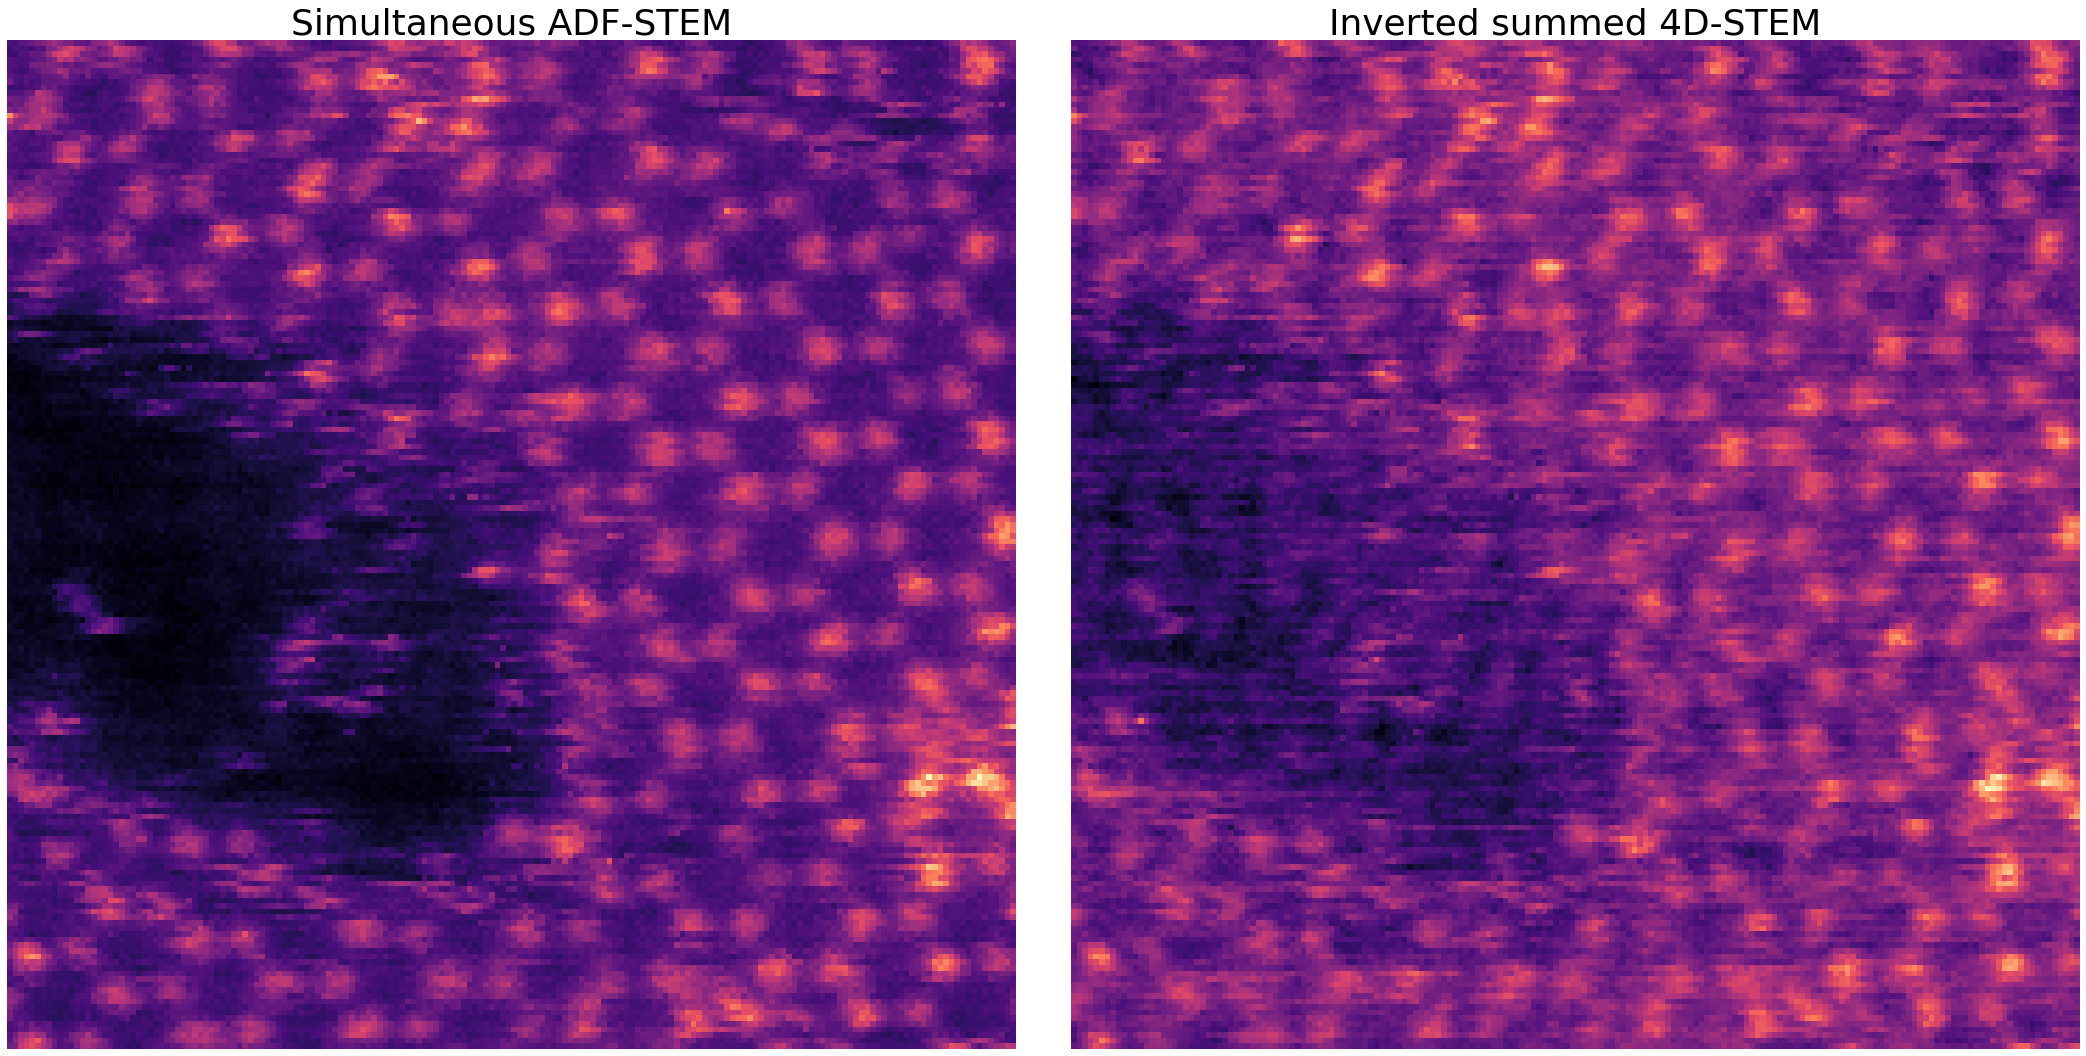

In [9]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(DataADF)
plt.axis('off')
plt.title('Simultaneous ADF-STEM')
plt.subplot(1,2,2)
plt.imshow(-np.sum(Data_4D,axis=(-1,-2)))
plt.axis('off')
plt.title('Inverted summed 4D-STEM')
plt.tight_layout()

In [10]:
Flat4D = np.reshape(Data_4D,(Data4Dshape[0]*Data4Dshape[1],Data4Dshape[2],Data4Dshape[3]))
CentralDisk = np.mean(Flat4D,axis=0)
del Data_4D

Text(0.5, 1.0, 'Diffraction Disk')

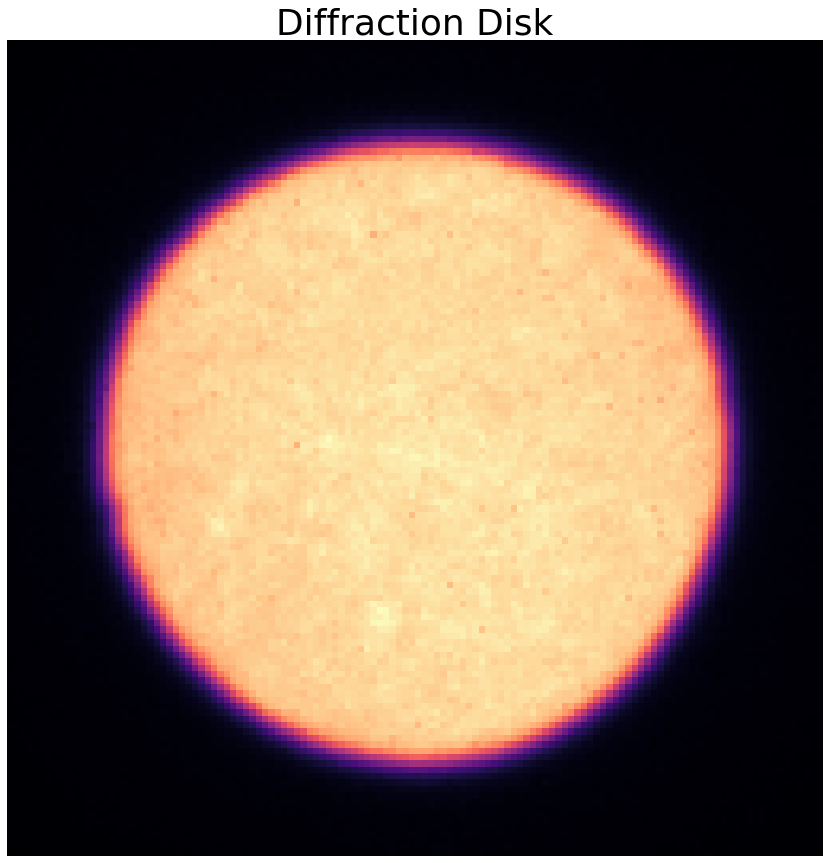

In [11]:
plt.figure(figsize=(15,15))
plt.imshow(CentralDisk)
plt.axis('off')
plt.title('Diffraction Disk')

In [12]:
ypos,xpos = np.mgrid[0:Data4Dshape[0],0:Data4Dshape[1]]
positions = (np.asarray((np.ravel(ypos),np.ravel(xpos)),dtype=int)).transpose()

In [13]:
beam_x,beam_y,beam_r = st.util.sobel_circle(CentralDisk)

In [14]:
beam_x,beam_y,beam_r

(63.93632479559607, 63.76628932024549, 48.78737603669326)

In [15]:
%timeit centerCBED(Flat4D[0:100,:,:])

223 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
st.tic()
Flat4D = centerCBED(Flat4D)
CentralDisk = np.mean(Flat4D,axis=0)
beam_x,beam_y,beam_r = st.util.sobel_circle(CentralDisk)
st.toc()

Elapsed time: 61.872717 seconds.



In [17]:
beam_x,beam_y,beam_r

(63.997841618463696, 63.992471198857466, 48.787417737241206)

In [18]:
%timeit get_flat_dpc(Flat4D[0:100,:,:])

66.7 ms ± 6.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
st.tic()
dpc_x,dpc_y = get_flat_dpc(Flat4D)
dpc_x = np.reshape(dpc_x,(1+positions[-1,0],1+positions[-1,1]))
dpc_y = np.reshape(dpc_y,(1+positions[-1,0],1+positions[-1,1]))
st.toc()

Elapsed time: 1.428413 seconds.



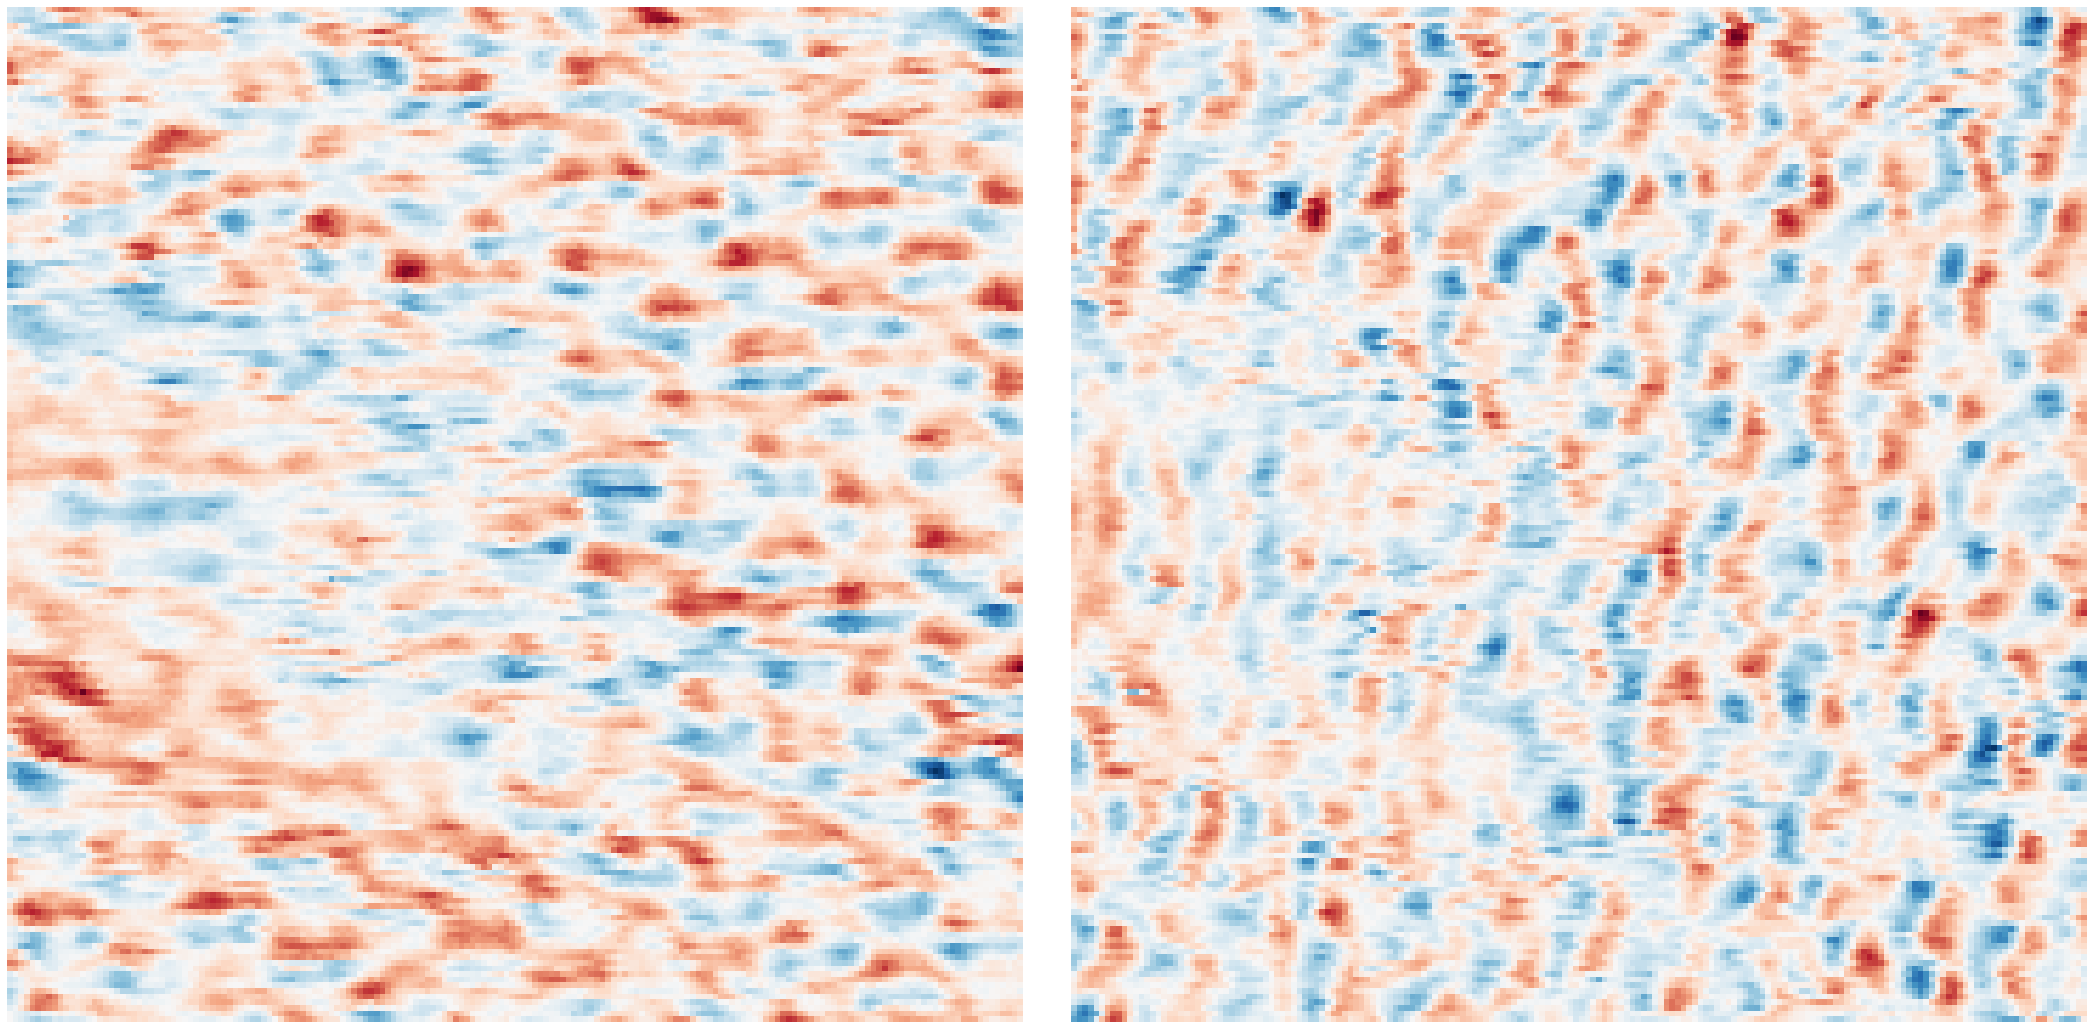

In [20]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(dpc_x,cmap='RdBu_r')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(dpc_y,cmap='RdBu_r')
plt.axis('off')
plt.tight_layout()

In [21]:
st.tic()
rotangle,flipval = optimize_angle(dpc_x,dpc_y,DataADF)
dpc_xC,dpc_yC = corrected_dpc(dpc_x,dpc_y,rotangle,flipval)
st.toc()

Elapsed time: 1.960172 seconds.



In [22]:
rotangle, flipval

(-101.50568166070548, False)

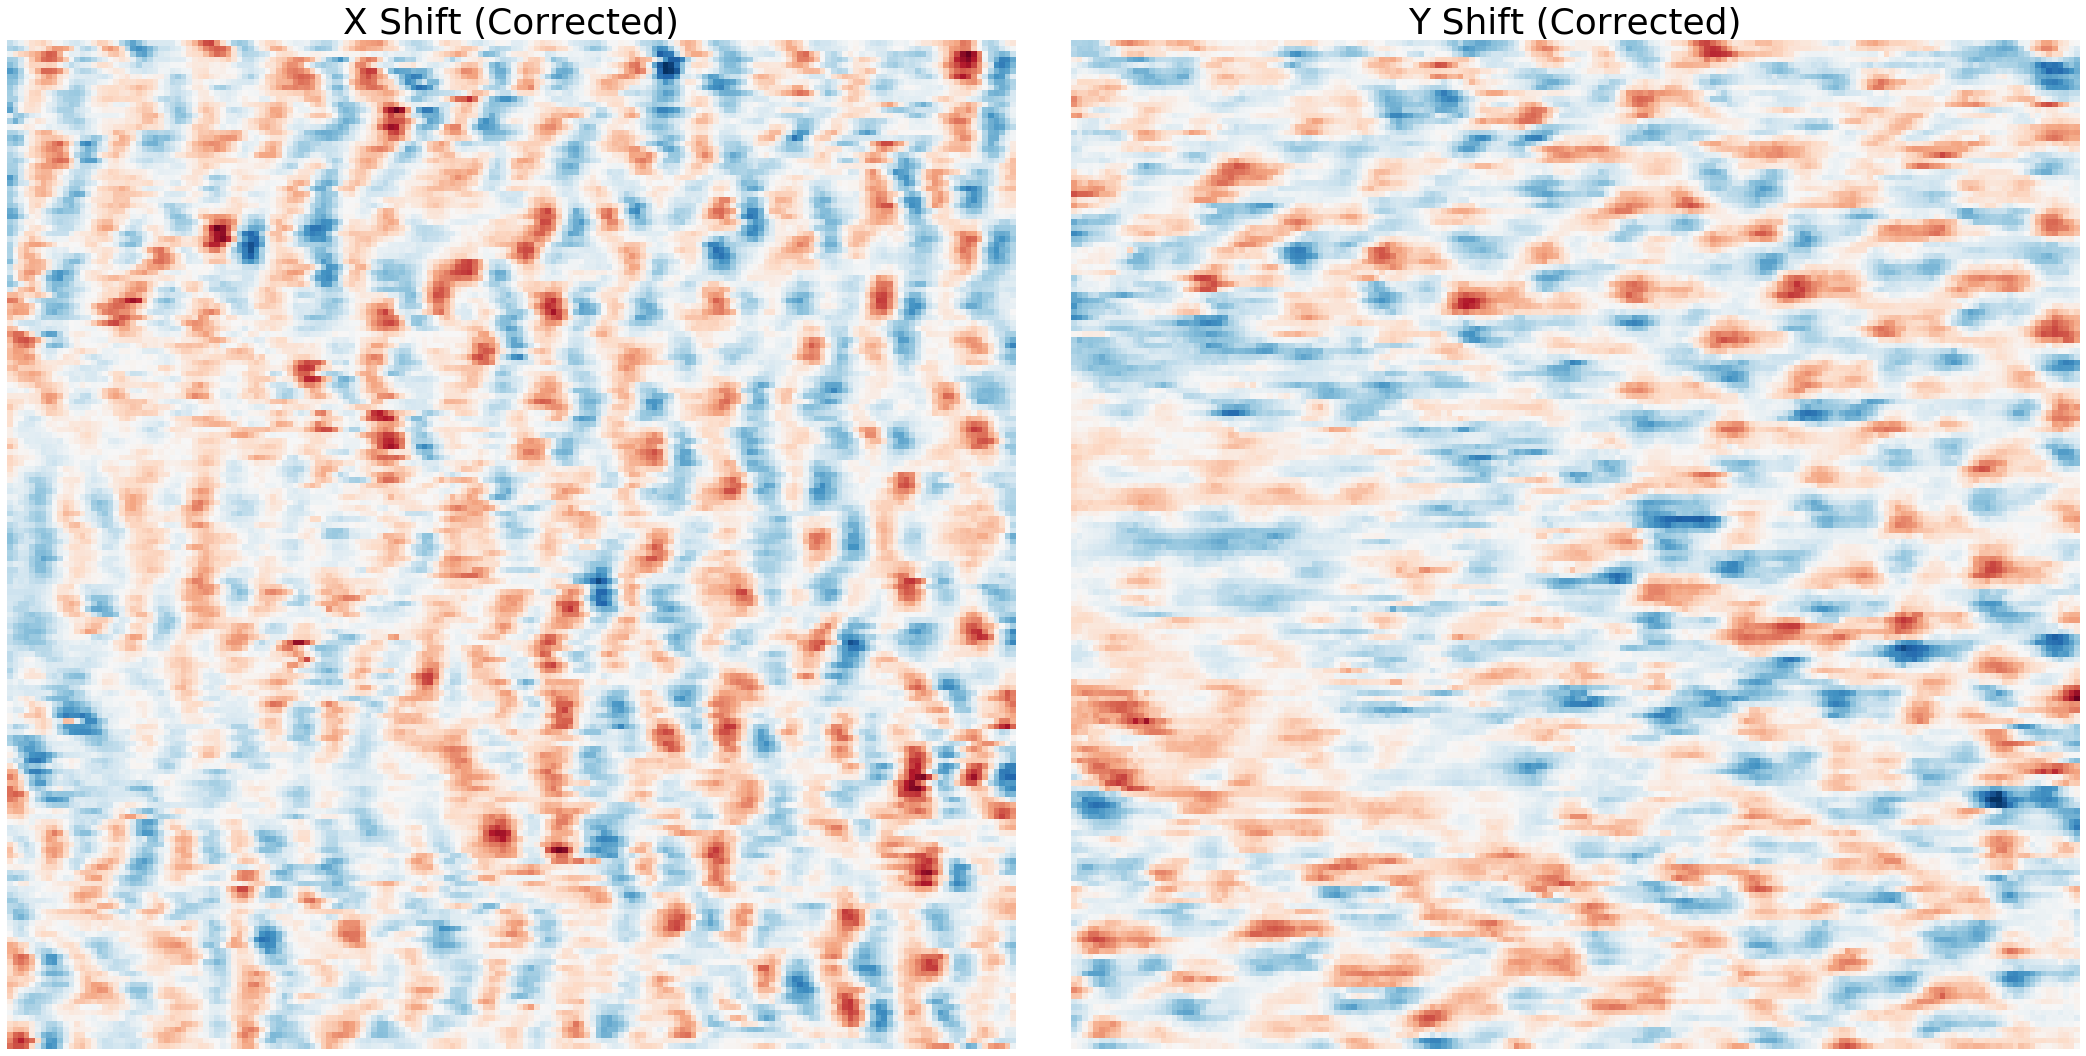

In [23]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(dpc_xC,cmap='RdBu_r')
plt.axis('off')
plt.title('X Shift (Corrected)')
plt.subplot(1,2,2)
plt.imshow(dpc_yC,cmap='RdBu_r')
plt.axis('off')
plt.title('Y Shift (Corrected)')
plt.tight_layout()

In [24]:
from scipy.interpolate import griddata as scigrid

@numba.jit(parallel=True,cache=True)
def im_rotator(image,rot_angle):
    imsize = np.asarray(image.shape)
    new_image = np.log((1 + image) - np.amin(image))
    rot_angle = np.deg2rad(rot_angle)
    oy, ox = imsize/2
    yy, xx = np.mgrid[0:imsize[0],0:imsize[1]]
    yyr = np.ravel(yy)
    xxr = np.ravel(xx)
    imr = np.ravel(new_image)
    xrot = np.zeros_like(xxr)
    yrot = np.zeros_like(yyr)
    for ii in numba.prange(len(yyr)):
        xrot[ii] = ox + (np.cos(rot_angle)*(xxr[ii] - ox)) - (np.sin(rot_angle)*(yyr[ii] - oy))
        yrot[ii] = oy + (np.sin(rot_angle)*(xxr[ii] - ox)) + (np.cos(rot_angle)*(yyr[ii] - oy))
    xrt = np.logical_and((xrot > 0),(xrot < imsize[1]))
    yrt = np.logical_and((yrot > 0),(yrot < imsize[0]))
    tr = np.logical_and(xrt,yrt)
    points = np.zeros((sum(tr),2))
    points[:,0] = xrot[tr]
    points[:,1] = yrot[tr]
    rot_im = scigrid(points,imr[tr], (xx, yy), method='cubic')
    rot_im[np.isnan(rot_im)] = np.amin(new_image)
    rot_im = np.exp(rot_im) + (np.amin(image) - 1)
    return rot_im

In [25]:
%timeit scnd.rotate(CentralDisk,57,reshape=False,order=5,mode='constant',cval=np.amin(CentralDisk))

9.12 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%timeit scnd.rotate(CentralDisk,57,reshape=False)

5.32 ms ± 37.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
%timeit im_rotator(CentralDisk,57)

711 ms ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


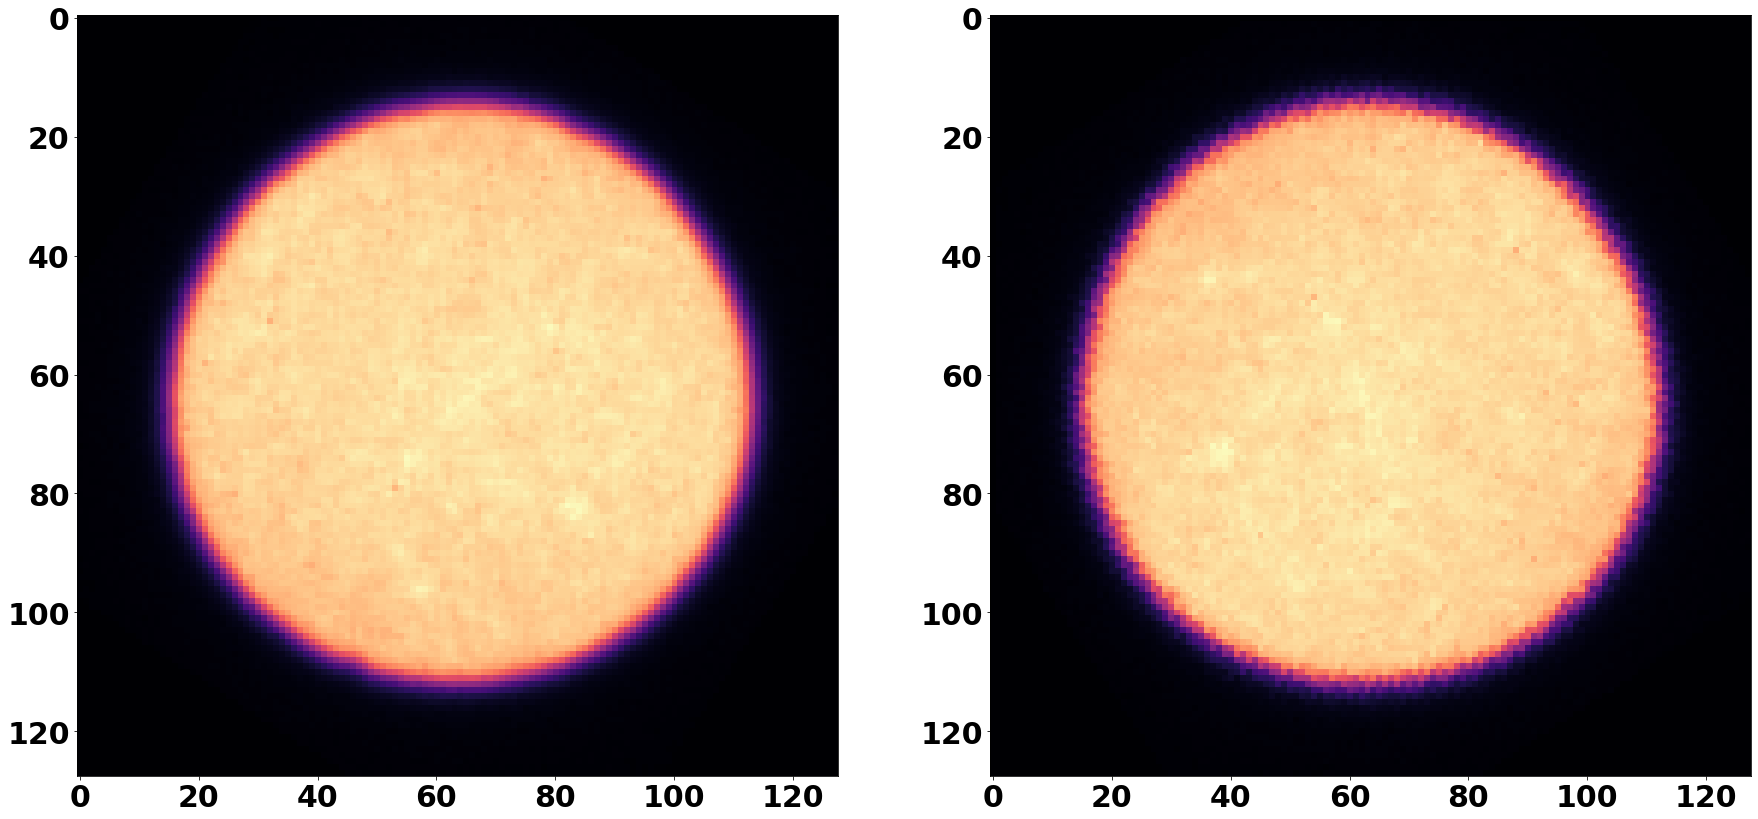

In [28]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(scnd.rotate(CentralDisk,57,reshape=False,order=5,mode='constant',cval=np.amin(CentralDisk)))
plt.subplot(1,2,2)
plt.imshow(im_rotator(CentralDisk,57))

In [29]:
%timeit rotator(Flat4D[0:2000,:,:],rotangle)

19.1 s ± 139 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
st.tic()
Flat4D = rotator(Flat4D,rotangle)
st.toc()

Elapsed time: 308.311510 seconds.



In [31]:
calib = infoADF['spatial_calibrations'][0]['scale']
calib_pm = 1000*calib

In [32]:
st.tic()
new_dpc_x,new_dpc_y = get_flat_dpc(Flat4D)
new_dpc_x = np.reshape(new_dpc_x,(1+positions[-1,0],1+positions[-1,1]))
new_dpc_y = np.reshape(new_dpc_y,(1+positions[-1,0],1+positions[-1,1]))
st.toc()

Elapsed time: 1.913425 seconds.



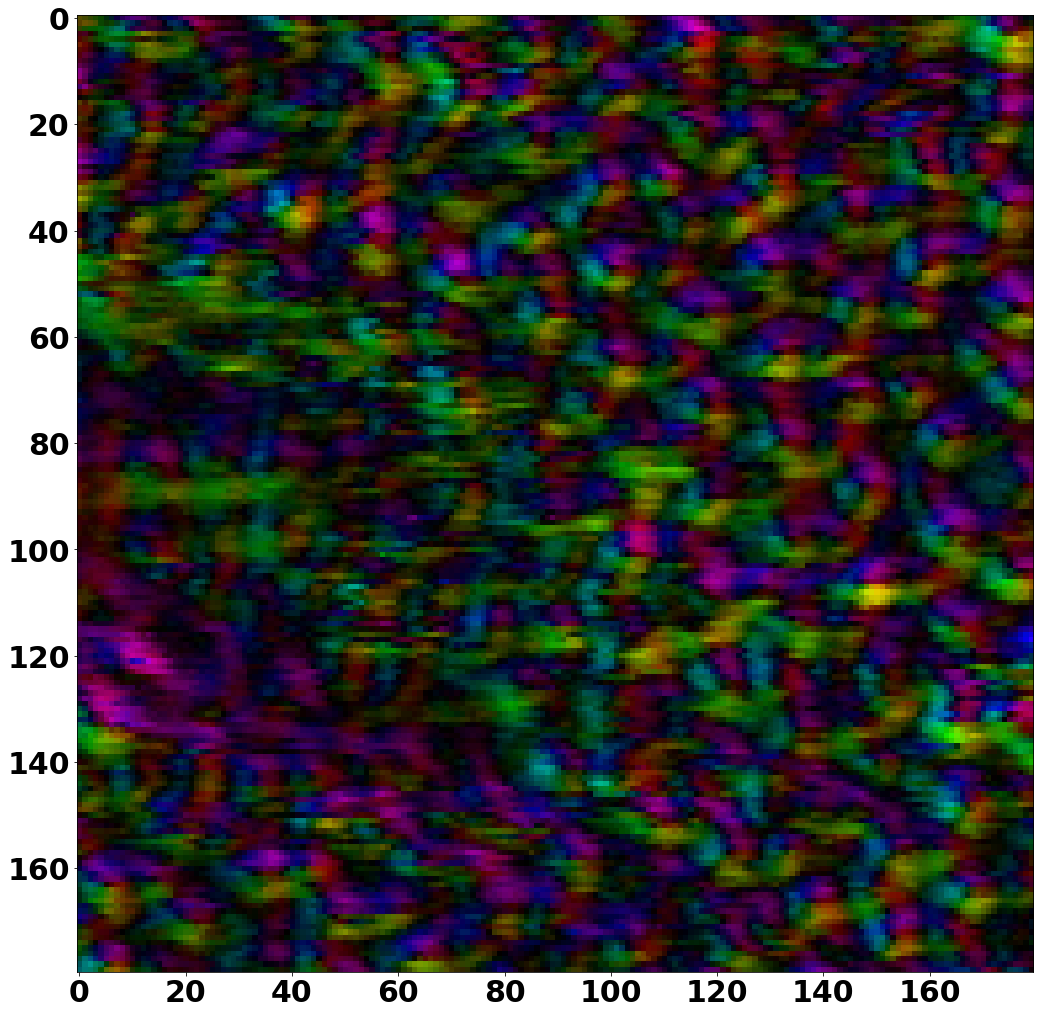

In [33]:
plt.figure(figsize=(15,15))
plt.imshow(st.util.cp_image_val(new_dpc_x + ((1j)*new_dpc_y)))
plt.tight_layout()

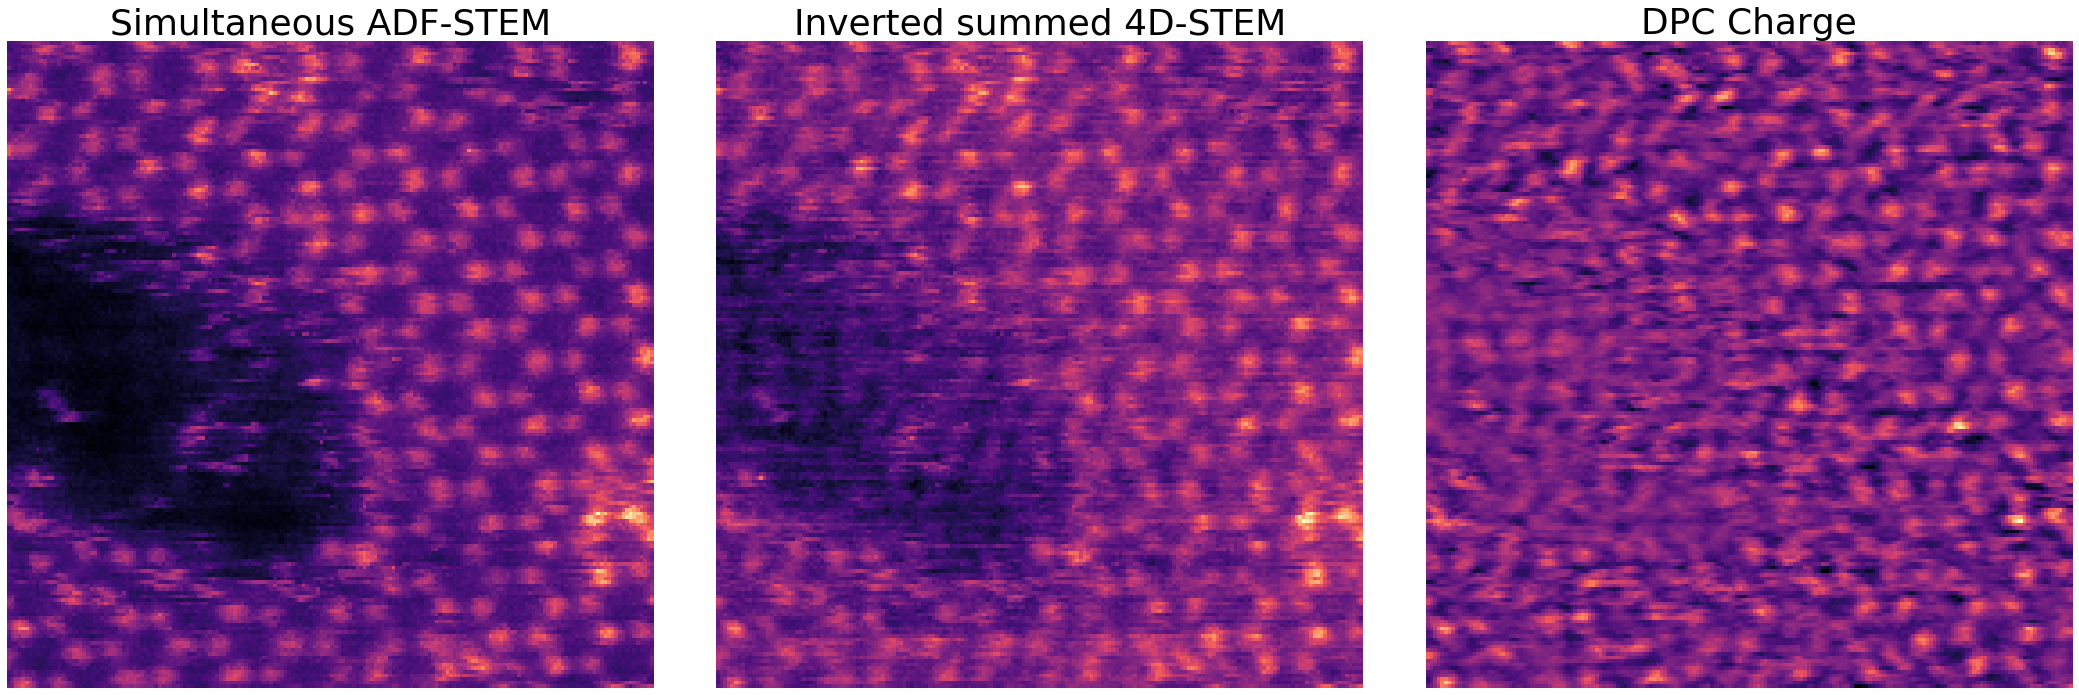

In [34]:
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(DataADF)
plt.axis('off')
plt.title('Simultaneous ADF-STEM')
plt.subplot(1,3,2)
plt.imshow(np.reshape((-np.sum(Flat4D,axis=(-1,-2))),(1+positions[-1,0],1+positions[-1,1])))
plt.axis('off')
plt.title('Inverted summed 4D-STEM')
plt.subplot(1,3,3)
plt.imshow(-charge_dpc(new_dpc_x,new_dpc_y))
plt.axis('off')
plt.title('DPC Charge')
plt.tight_layout()

In [35]:
aperture_sa = 31/1000
beam_calib = (aperture_sa/(100*st.beam.wavelength_ang(60)))/beam_r
beam_calib

0.00013057992166062534

In [36]:
current_size = 1+positions[-1,:]
padding = 2000 #in picometers
pad_pixels = int(padding/calib_pm)
new_size = (current_size + 2*pad_pixels).astype(int)
pad_positions = (positions + pad_pixels).astype(int)
start_psi = np.ones(new_size,dtype=np.complex64)

In [37]:
ideal_radius = (np.sum(np.abs(np.fft.fftshift(np.fft.fft2(st.beam.make_probe(1000*aperture_sa,60,new_size,calib_pm)))))/np.pi)**0.5
sampling = beam_r/ideal_radius
sampling

0.9586291046825046

In [38]:
Flat4D.dtype

dtype('float64')

In [39]:
st.tic()
Flat4D = cy_resizer4Df(Flat4D.astype(np.float32),sampling)
st.toc()

Elapsed time: 17.952222 seconds.



In [40]:
st.tic()
cc = subpixel_pad4D(Flat4D[0:4000,:,:],new_size,1.1*ideal_radius)
st.toc()

Elapsed time: 154.323309 seconds.



In [41]:
%timeit subpixel_pad4D_numba(Flat4D[0:500,:,:],new_size,1.1*ideal_radius)

8.86 s ± 474 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
st.tic()
Flat4D = subpixel_pad4D_numba(Flat4D,new_size,1.1*ideal_radius)
st.toc()

Elapsed time: 545.339264 seconds.



In [43]:
Flat4D.shape

(32400, 360, 360)

Text(0.5, 1.0, 'Processed Diffraction Disk')

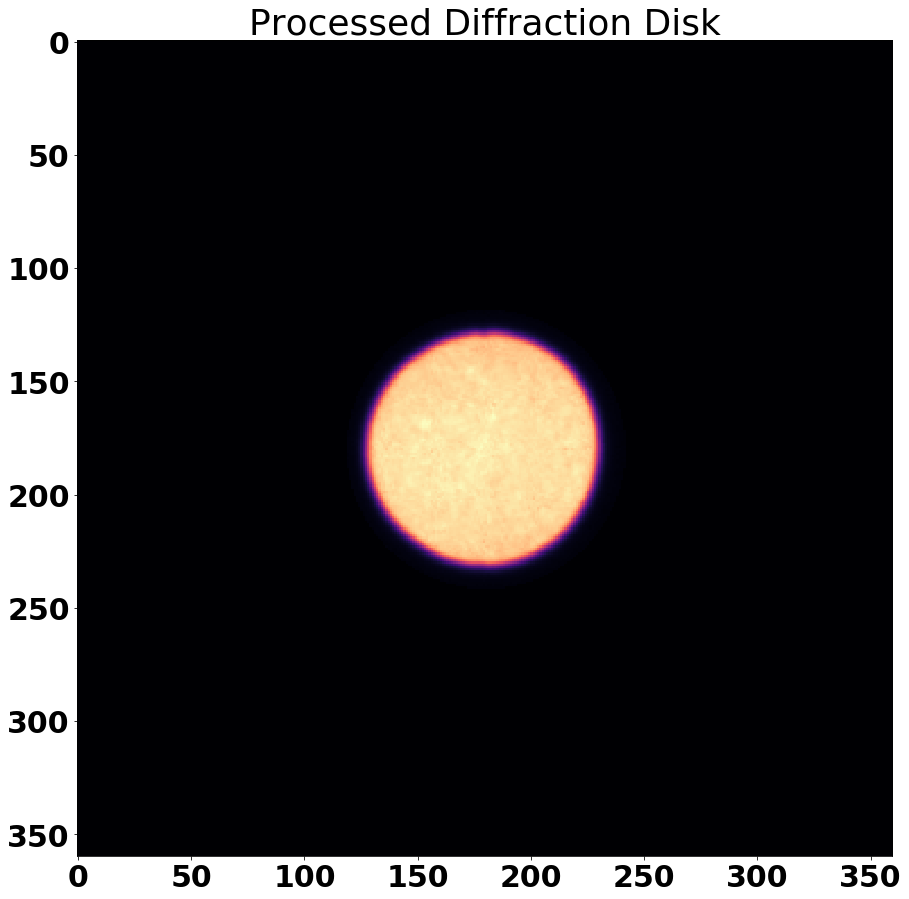

In [44]:
plt.figure(figsize=(15,15))
plt.imshow(np.mean(Flat4D,axis=0))
plt.title('Processed Diffraction Disk')

In [45]:
@numba.jit(cache=True,parallel=True)
def numba_squared(data4D_flat):
    data4D_final = np.zeros_like(data4D_flat,dtype=data4D_flat.dtype)
    temp = np.zeros(data4D_flat.shape[1:3],dtype=data4D_flat.dtype)
    data_max = np.amax(data4D_flat)
    data_min = np.amin(data4D_flat)
    data_range = data_max - data_min
    for ii in numba.prange(data4D_flat.shape[0]):
        temp = data4D_flat[ii,:,:]
        temp = (temp - data_min)/data_range
        data4D_final[ii,:,:] = temp ** 0.5
    return data4D_final

In [46]:
%timeit numba_squared(Flat4D[0:100,:,:])

84.6 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Since `numba` is much faster, that's what we will use

In [47]:
st.tic()
Flat4D_sq = numba_squared(Flat4D)
st.toc()

Elapsed time: 20.606674 seconds.



Text(0.5, 1.0, 'Processed Squared Diffraction Disk')

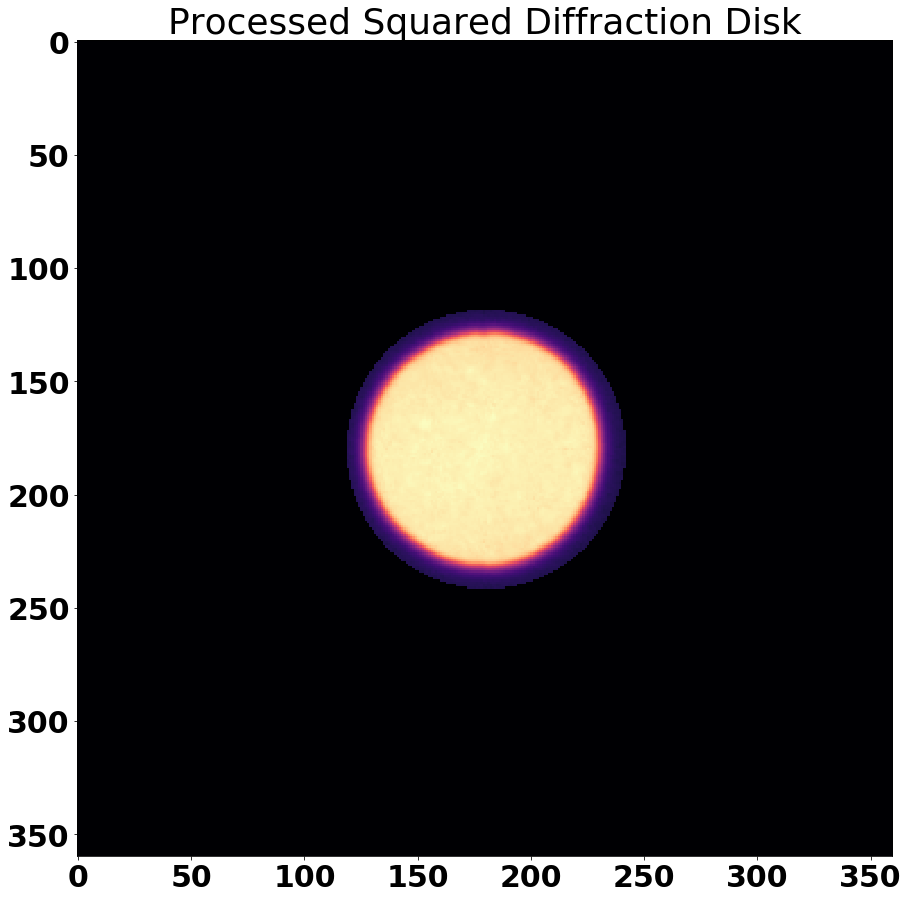

In [48]:
plt.figure(figsize=(15,15))
plt.imshow(np.mean(Flat4D_sq,axis=0))
plt.title('Processed Squared Diffraction Disk')

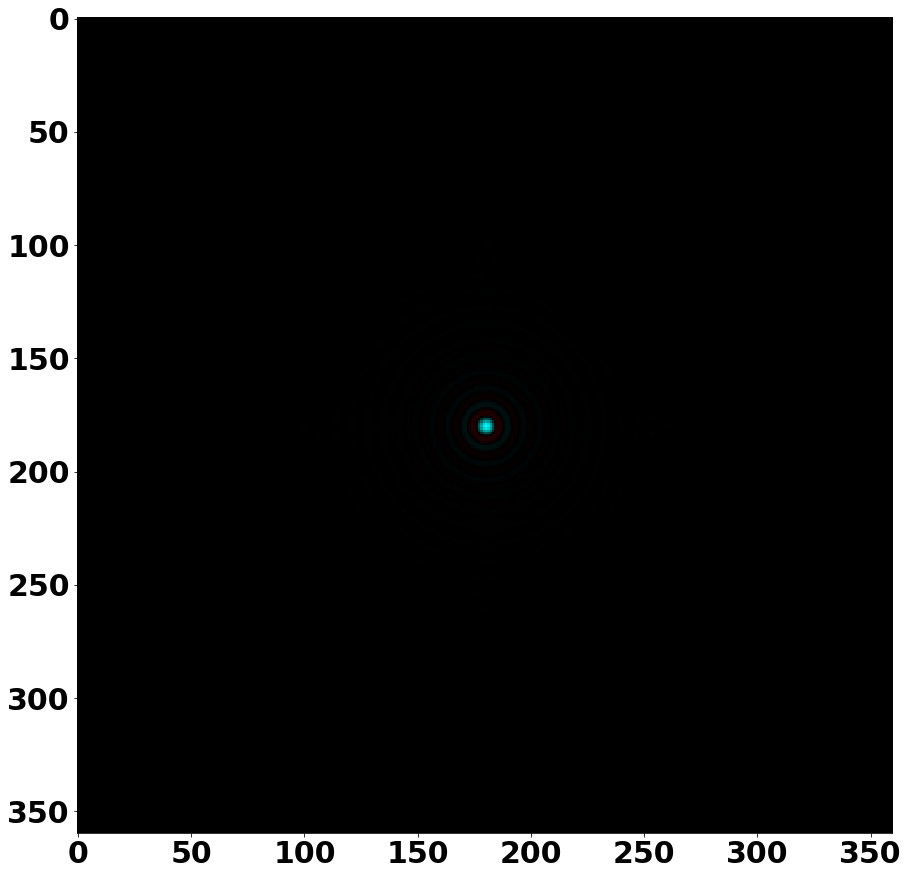

In [49]:
pure_probe = st.beam.make_probe(1000*aperture_sa,60,new_size,calib_pm)
plt.figure(figsize=(15,15))
plt.imshow(st.util.cp_image_val(pure_probe))

In [85]:
@numba.jit(cache=True,parallel=True)
def one_pie_slice(positions,psi,probe,data4D_sq,alpha=0.01):
    pfi.cache.enable()
    image_size = np.asarray(psi.shape)
    nova_psi_prb = np.zeros((len(positions),image_size[0],image_size[1]),dtype=np.complex64)
    fourier_cal_y = (np.linspace((-image_size[0]/2), ((image_size[0]/2) - 1), image_size[0]))/image_size[0]
    fourier_cal_x = (np.linspace((-image_size[1]/2), ((image_size[1]/2) - 1), image_size[1]))/image_size[1]
    [fourier_mesh_x, fourier_mesh_y] = np.meshgrid(fourier_cal_x, fourier_cal_y)
    fourier_mesh_x = (-2) * np.pi * 1j * fourier_mesh_x
    fourier_mesh_y = (-2) * np.pi * 1j * fourier_mesh_y
    prb_pixels =  np.fliplr(positions) - np.flip(image_size/2)
    obj_pixels =  np.flip(image_size/2) - np.fliplr(positions)
    probe_ft = np.fft.fft2(probe)
    prb_mover = np.zeros_like(fourier_mesh_x,dtype=np.complex64)
    obj_mover = np.zeros_like(fourier_mesh_x,dtype=np.complex64)
    new_psi = np.zeros_like(fourier_mesh_x,dtype=np.complex64)
    mvd_psi = np.zeros_like(fourier_mesh_x,dtype=np.complex64)
    mp = np.zeros_like(fourier_mesh_x,dtype=np.complex64)
    chi = np.zeros_like(fourier_mesh_x,dtype=np.complex64)
    temp = np.zeros_like(fourier_mesh_x,dtype=np.complex64)
    for ii in numba.prange(len(positions)):
        prb_mover = np.exp((fourier_mesh_x*prb_pixels[ii,0]) + (fourier_mesh_y*prb_pixels[ii,1]))
        obj_mover = np.exp((fourier_mesh_x*obj_pixels[ii,0]) + (fourier_mesh_y*obj_pixels[ii,1]))
        mp = pfi.numpy_fft.ifft2(prb_mover*probe_ft)
        chi = np.fft.fftshift(pfi.numpy_fft.fft2(mp*psi))
        temp = np.exp((1j)*np.angle(chi))
        new_psi = np.fft.ifftshift(pfi.numpy_fft.ifft2(data4D_sq[ii,:,:]*temp))
        mvd_psi = pfi.numpy_fft.ifft2(obj_mover*(data4D_sq[ii,:,:]*temp))
        nova_psi_prb[ii,:,:] = new_psi
    return nova_psi_prb

In [86]:
test_num = 32
%timeit one_pie_slice(pad_positions[0:test_num,:],start_psi,pure_probe,Flat4D_sq[0:test_num,:,:])

4.33 s ± 38.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [94]:
@dask.delayed()
def dask_pie(fourier_mesh_x,fourier_mesh_y,prb_pixel,obj_pixel,probe_ft,data4D,psi):
    prb_mover = np.exp((fourier_mesh_x*prb_pixel[0]) + (fourier_mesh_y*prb_pixel[1]))
    obj_mover = np.exp((fourier_mesh_x*obj_pixel[0]) + (fourier_mesh_y*obj_pixel[1]))
    mp = pfi.numpy_fft.ifft2(prb_mover*probe_ft)
    chi = np.fft.fftshift(pfi.numpy_fft.fft2(mp*psi))
    temp = np.exp((1j)*np.angle(chi))
    new_psi = np.fft.ifftshift(pfi.numpy_fft.ifft2(data4D*temp))
    mvd_psi = pfi.numpy_fft.ifft2(obj_mover*(data4D*temp))
    return mvd_psi
    
def one_pie_slice_dask(positions,psi,probe,data4D_sq,alpha=0.01):
    pfi.cache.enable()
    image_size = np.asarray(psi.shape)
    data4D_dask = da.from_array(data4D_sq,chunks=('auto',-1,-1))
    fourier_cal_y = (np.linspace((-image_size[0]/2), ((image_size[0]/2) - 1), image_size[0]))/image_size[0]
    fourier_cal_x = (np.linspace((-image_size[1]/2), ((image_size[1]/2) - 1), image_size[1]))/image_size[1]
    [fourier_mesh_x, fourier_mesh_y] = np.meshgrid(fourier_cal_x, fourier_cal_y)
    fourier_mesh_x = (-2) * np.pi * 1j * fourier_mesh_x
    fourier_mesh_y = (-2) * np.pi * 1j * fourier_mesh_y
    prb_pixels =  np.fliplr(positions) - np.flip(image_size/2)
    obj_pixels =  np.flip(image_size/2) - np.fliplr(positions)
    probe_ft = np.fft.fft2(probe)
    computed_4D = []
    for ii in range(len(positions)):
        p = dask_pie(fourier_mesh_x,fourier_mesh_y,prb_pixels[ii,0:2],obj_pixels[ii,0:2],probe_ft,data4D_dask[ii,:,:],psi)
        computed_4D.append(p)
    computed_4D = dask.compute(*computed_4D)
    return np.asarray(computed_4D)

In [98]:
test_num = 400
st.tic()
cc = one_pie_slice_dask(pad_positions[0:test_num,:],start_psi,pure_probe,Flat4D_sq[0:test_num,:,:])
st.toc()

Elapsed time: 29.053760 seconds.



In [97]:
@numba.jit(cache=True,parallel=True)
def get_move_matrix(positions,im_size,probe=True):
    move_mat = np.zeros((len(positions),im_size[0],im_size[1]),dtype=np.complex64)
    image_size = np.asarray(im_size)
    fourier_cal_y = (np.linspace((-image_size[0]/2), ((image_size[0]/2) - 1), image_size[0]))/image_size[0]
    fourier_cal_x = (np.linspace((-image_size[1]/2), ((image_size[1]/2) - 1), image_size[1]))/image_size[1]
    [fourier_mesh_x, fourier_mesh_y] = np.meshgrid(fourier_cal_x, fourier_cal_y)
    fourier_mesh_x = (-2) * np.pi * 1j * fourier_mesh_x
    fourier_mesh_y = (-2) * np.pi * 1j * fourier_mesh_y
    if probe:
        move_pixels =  np.fliplr(positions) - np.flip(image_size/2)
    else:
        move_pixels =  np.flip(image_size/2) - np.fliplr(positions)
    for ii in numba.prange(len(positions)):
        move_mat[ii,:,:] = np.exp((fourier_mesh_x*move_pixels[ii,0]) + (fourier_mesh_y*move_pixels[ii,1]))
    return move_mat

@numba.jit(cache=True,parallel=True)
def move_prb_obj(probe,move_mat):
    moved_probe = np.zeros_like(move_mat,dtype=move_mat.dtype)
    mp = np.zeros_like(probe,dtype=move_mat.dtype)
    probe_ft = np.fft.fft2(probe)
    for ii in numba.prange(move_mat.shape[0]):
        mp = move_mat[ii,:,:]*probe_ft
        moved_probe[ii,:,:] = np.fft.ifft2(mp)
    return moved_probe

@numba.jit(cache=True,parallel=True)
def get_chi_function(psi,probe,move_mat):
    chi = np.zeros_like(move_mat,dtype=move_mat.dtype)
    mp = np.zeros_like(probe,dtype=move_mat.dtype)
    probe_ft = np.fft.fft2(probe)
    for ii in numba.prange(move_mat.shape[0]):
        mp = np.fft.ifft2(move_mat[ii,:,:]*probe_ft)
        chi[ii,:,:] = np.fft.fftshift(np.fft.fft2(mp*psi))
    return chi

@numba.jit(cache=True,parallel=True)
def new_chi(old_chi,squared4D):
    nova_chi = np.zeros_like(old_chi,dtype=old_chi.dtype)
    temp = np.zeros(old_chi.shape[1:3],dtype=old_chi.dtype)
    for ii in numba.prange(old_chi.shape[0]):
        temp = np.exp((1j)*np.angle(old_chi[ii,:,:]))
        nova_chi[ii,:,:] = np.fft.ifftshift(np.fft.ifft2(squared4D[ii,:,:]*temp))
    return nova_chi

@numba.jit(cache=True,parallel=True)
def back_propagate(old_psi):
    new_psi = np.zeros_like(old_psi,dtype=old_psi.dtype)
    temp = np.zeros(old_psi.shape[1:3],dtype=old_psi.dtype)
    for ii in numba.prange(old_psi.shape[0]):
        temp = old_psi[ii,:,:]
        new_psi[ii,:,:] = np.fft.ifft2(temp)
    return new_psi

In [54]:
%timeit get_move_matrix(pad_positions[0:50,:],new_size)

143 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
@dask.delayed
def dask_move_prb_matrix(position,fourier_mesh_x,fourier_mesh_y):
    move_pixels =  np.fliplr(positions) - np.flip(np.asarray(fourier_mesh_x.shape)/2)
    move_mat = np.exp((fourier_mesh_x*move_pixels[0,0]) + (fourier_mesh_y*move_pixels[0,1]))
    return move_mat

@dask.delayed
def dask_move_obj_matrix(position,fourier_mesh_x,fourier_mesh_y):
    move_pixels =   np.flip(np.asarray(fourier_mesh_x.shape)/2) - np.fliplr(positions)
    move_mat = np.exp((fourier_mesh_x*move_pixels[0,0]) + (fourier_mesh_y*move_pixels[0,1]))
    return move_mat

@dask.delayed
def dask_get_chi(prb_ft,obj,mover):
    prb_moved = np.fft.ifft2(mover*prb_ft)
    chi = np.fft.fftshift(np.fft.fft2(obj,prb_moved))
    return chi

@dask.delayed
def dask_new_chi(old_chi,cbd):
    temp = np.exp((1j)*np.angle(old_chi))
    new_chi = np.fft.ifftshift(np.fft.ifft2(cbd*temp))
    return new_chi

def single_PIE(data4D_sq,positions,prb,obj):
    image_size = np.asarray(data4D_sq.shape[1:3])
    fourier_cal_y = (np.linspace((-image_size[0]/2), ((image_size[0]/2) - 1), image_size[0]))/image_size[0]
    fourier_cal_x = (np.linspace((-image_size[1]/2), ((image_size[1]/2) - 1), image_size[1]))/image_size[1]
    [fourier_mesh_x, fourier_mesh_y] = np.meshgrid(fourier_cal_x, fourier_cal_y)
    fourier_mesh_x = (-2) * np.pi * 1j * fourier_mesh_x
    fourier_mesh_y = (-2) * np.pi * 1j * fourier_mesh_y
    prb_ft = np.fft.fft2(prb)
    chi_func = []
    for ii in range(data4D_sq.shape[0]):
        pos = positions[ii,:]
        cbed = data4D_sq[ii,:,:]
        prb_mover = dask_move_prb_matrix(pos,fourier_mesh_x,fourier_mesh_y)
        chi = dask_get_chi(prb_ft,obj,prb_mover)
        new_chi = dask_new_chi(chi,cbed)
        chi_func.append(new_chi)
    chi_func = dask.compute(*chi_func)
    chi_func = np.asarray(chi_func)
    return chi_func

In [ ]:
st.tic()
nc = single_PIE(Flat4D_sq,pad_positions,pure_probe,start_psi)
st.toc()